In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
from sklearn.preprocessing import minmax_scale
from scipy.signal import resample
import heartpy as hp
import warnings
warnings.filterwarnings('ignore')

In [3]:
source_dir = 'D:/Dropbox/raw_signals_org/'

rawdata_list = os.listdir(source_dir)
print(len(rawdata_list))

1285


In [4]:
def get_difference_list(seq):
    seq  = np.concatenate([[0], seq, [0]])
    differ = seq[1:] - seq[:-1]
    differ = differ[1:-1]
    return differ

In [5]:
def check_abp(abp, sig_length=1500, fs=125):

    ABP = minmax_scale(abp)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if ABP.shape[0] > 1:
        ABP = ABP.T

    try:
        wd_a, _ = hp.process(ABP, sample_rate=fs) # peak detection
    except Exception:
        return {'result': 1, 'reason': 'heartpy 사용중 error'}
    
    # Peak
    pks_ABP = wd_a['peaklist']  # peak location list
    pks_ABP = np.array(pks_ABP)

    # Valley
    P2PIDX =  np.concatenate([pks_ABP[:-1][..., np.newaxis], pks_ABP[1:][..., np.newaxis] ], axis=-1)
    val_ABP =  np.unique([np.argmin(ABP[i[0]:i[1]]) +i[0]  for i in P2PIDX])

    if pks_ABP[-1] == (sig_length-1):
        pks_ABP = np.delete(pks_ABP,-1)

    # Peak
    peak_dist_ABP = get_difference_list(pks_ABP) # Interval between peaks
    std_peak_dist_ABP = np.std(peak_dist_ABP)    # feature1
    std_peaks_ABP = np.std(ABP[pks_ABP])         # feature2
    num_peaks_ABP = len(pks_ABP)                 # feature3
    max_min_differ_pks = np.max(ABP[pks_ABP]) - np.min(ABP[pks_ABP]) # feature 4
    differ_pks = get_difference_list(ABP[pks_ABP])
    max_differ_pks = max(np.abs(differ_pks))     # feature 5
    
    # Bad signal detection through peak
    if (std_peaks_ABP > 0.12):
        return {'result': 1, 'reason': 'peak들의 std가 0.12 초과'}
    if (std_peak_dist_ABP > 10):
        return {'result': 1, 'reason': 'peak간격의 std가 10 초과'}
    if (num_peaks_ABP < int(sig_length/(fs*1.5))) or (num_peaks_ABP > int(sig_length/(fs*0.4))):
        return {'result': 1, 'reason': '박동이 너무 빠르거나 느림(peak)'}
    if (max_min_differ_pks > 0.25):
        return {'result': 1, 'reason': '최대 peak와 최소 peak 차이가 0.25 초과'}
    if (max_differ_pks > 0.18):
        return {'result': 1, 'reason': 'peak간 차분값의 최댓값이 0.18 초과'}
    
    # If the first peak is detected too late or the last peak is detected too early => bad signal
    if (pks_ABP[0] > 2*np.mean(peak_dist_ABP)) or (sig_length - pks_ABP[-1] > 2*np.mean(peak_dist_ABP)):
        return {'result': 1, 'reason': '첫번째 peak가 너무 늦게 검출되거나, 마지막 peak가 너무 이르게 검출됌'}

    # valley
    valley_dist_ABP = get_difference_list(val_ABP) # Interval between valleys
    std_valley_dist_ABP = np.std(valley_dist_ABP)  # feature 6
    std_valley_ABP = np.std(ABP[val_ABP])          # feature 7
    num_valley_ABP = len(val_ABP)                  # feature 8
    max_min_differ_val = np.max(ABP[val_ABP]) - np.min(ABP[val_ABP]) # feature 9
    differ_val = get_difference_list(ABP[val_ABP])
    max_differ_val = max(np.abs(differ_val))       # feature 10

    # Bad signal detection through valley
    if (std_valley_ABP > 0.12):
        return {'result': 1, 'reason': 'valley들의 std가 0.12 초과'}
    if (std_valley_dist_ABP > 25):
        return {'result': 1, 'reason': 'valley간격의 std가 25 초과'}
    if (num_valley_ABP < int(sig_length/(fs*1.5))) or (num_valley_ABP > int(sig_length/(fs*0.4))):
        return {'result': 1, 'reason': '박동이 너무 빠르거나 느림(valley)'}
    if (max_min_differ_val > 0.25):
        return {'result': 1, 'reason': '최대 valley와 최소 valley 차이가 0.25 초과'}
    if (max_differ_val > 0.18):
        return {'result': 1, 'reason': 'valley간 차분값의 최댓값이 0.18 초과'}
    
    return {'result': 0, 'reason': '정상'}

In [6]:
def check_ppg(ppg, sig_length=1500, fs=125):
    if np.mean(ppg)>=1:
        ppg = ppg/4

    PPG = minmax_scale(ppg)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if PPG.shape[0] > 1:
        PPG = PPG.T

    try:
        wd_p, _ = hp.process(PPG, sample_rate=fs) # peak detection
    except Exception:
        return {'result': 1, 'reason': 'heartpy 사용중 error'}

    # Peak
    pks_PPG = wd_p['peaklist'] # peak location list
    pks_PPG = np.array(pks_PPG)

    # Valley
    P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
    val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])  

    if all(np.gradient(PPG[-3:])>=0):
        val_PPG = np.concatenate([val_PPG, [np.argmin(PPG[pks_PPG[-1]:len(PPG)])+pks_PPG[-1]]], axis=-1)

    if pks_PPG[-1] == (sig_length-1):
        pks_PPG = np.delete(pks_PPG,-1)
        
    # peak feature
    peak_dist_PPG = get_difference_list(pks_PPG) # Interval between peaks
    std_peak_dist_PPG = np.std(peak_dist_PPG)    # feature 1
    std_peaks_PPG = np.std(PPG[pks_PPG])         # feature 2
    num_peaks_PPG = len(pks_PPG)                 # feature 3
    max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # feature 4
    differ_pks = get_difference_list(PPG[pks_PPG])
    max_differ_pks = max(np.abs(differ_pks))     # feature 5


    # Bad signal detection through peak
    if (std_peaks_PPG > 0.12):
        return {'result': 1, 'reason': 'peak들의 std가 0.12 초과'}
    if (std_peak_dist_PPG > 10):
        return {'result': 1, 'reason': 'peak간격의 std가 10 초과'}
    if (num_peaks_PPG < int(sig_length/(fs*1.5))) or (num_peaks_PPG > int(sig_length/(fs*0.4))):
        return {'result': 1, 'reason': '박동이 너무 빠르거나 느림(peak)'}
    if (max_min_differ_pks > 0.25):
        return {'result': 1, 'reason': '최대 peak와 최소 peak 차이가 0.25 초과'}
    if (max_differ_pks > 0.18):
        return {'result': 1, 'reason': 'peak간 차분값의 최댓값이 0.18 초과'}

    # If the first peak is detected too late or the last peak is detected too early => bad signal
    if (pks_PPG[0] > 2*np.mean(peak_dist_PPG)) or (sig_length - pks_PPG[-1] > 2*np.mean(peak_dist_PPG)):
        return {'result': 1, 'reason': '첫번째 peak가 너무 늦게 검출되거나, 마지막 peak가 너무 이르게 검출됌'}


    # valley feature
    valley_dist_PPG = get_difference_list(val_PPG)  # Interval between valleys
    std_valley_dist_PPG = np.std(valley_dist_PPG)   # feature 6
    std_valley_PPG = np.std(PPG[val_PPG])           # feature 7
    num_valley_PPG = len(val_PPG)                   # feature 8
    max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # feature 9
    differ_val = get_difference_list(PPG[val_PPG])
    max_differ_val = max(np.abs(differ_val))        # feature 10

    # Bad signal detection through valley
    if (std_valley_PPG > 0.12):
        return {'result': 1, 'reason': 'valley들의 std가 0.12 초과'}
    if (std_valley_dist_PPG > 25):
        return {'result': 1, 'reason': 'valley간격의 std가 25 초과'}
    if (num_valley_PPG < int(sig_length/(fs*1.5))) or (num_valley_PPG > int(sig_length/(fs*0.4))):
        return {'result': 1, 'reason': '박동이 너무 빠르거나 느림(valley)'}
    if (max_min_differ_val > 0.25):
        return {'result': 1, 'reason': '최대 valley와 최소 valley 차이가 0.25 초과'}
    if (max_differ_val > 0.18):
        return {'result': 1, 'reason': 'valley간 차분값의 최댓값이 0.18 초과'}

    return {'result': 0, 'reason': '정상'}

In [7]:
source_dir = 'D:/Dropbox/raw_signals_org/'
output_dir = 'D:/Dropbox/ART_PPG/'

time_len = 12
fs0 = 125 # Before change sampling rate
fs1 = 100 # After change sampling rate
intv = fs0 * time_len # segment length / (sampling rate)*(seconds)

In [ ]:
file_num = len(rawdata_list)
total_data_num = 0

for idx, p in enumerate(rawdata_list):   # range(len(rawdata_list)):

    wf_dic = dict()
    wf_dic['ART'] = list()
    wf_dic['PLETH'] = list()
    data_num = 0 

    data = np.load(source_dir + p, allow_pickle=True) # raw_signal_load
    rec_nb = len(data['record_name'])                 # number of records for one patient
    print(f'checking ({idx+1}/{file_num})th file, rec_num: {rec_nb}')

    for i in range(rec_nb):
        L = data['sig_len'][i]  # signal length of a record
        print(f'({idx+1}/{file_num})file-({i+1}/{rec_nb})rec. rec_len: {L}')
        abp0 = data['ART'][i]   # whole ART in a record
        ppg0 = data['PLETH'][i] # whole PPG in a record

        for j in range(0, L//intv):   
            abpf = abp0[intv*j:intv*(j+1)]
            ppgf = ppg0[intv*j:intv*(j+1)]
            
            # NA -> continue
            if (np.sum(np.isnan(abpf)) > 0) or (np.sum(np.isnan(ppgf)) > 0):
                continue
            # Limit ABP to a range of 30 to 220 and limit PPG to a positive number.
            if (np.min(abpf) < 20) or (np.max(abpf) > 220) or (np.min(ppgf) < 0):
                continue

            # bad signal Decision
            if check_ppg(ppgf)['result']==1:
                continue
            if check_abp(abpf)['result']==1:
                continue
            
            # If ppg range is 0~4, change it to 0~1 and save
            if np.mean(ppgf)>=1:
                ppgf = ppgf/4

            wf_dic['ART'].append(np.array(resample(abpf, fs1*time_len)))
            wf_dic['PLETH'].append(np.array(resample(ppgf, fs1*time_len)))
            data_num+=1

    if len(wf_dic['ART']) != 0:
        np.savez_compressed(output_dir + 'CleanSet' + str(idx+1), **wf_dic)
    total_data_num+=data_num
    print(f'{data_num} data from {idx+1}th file. total data: {total_data_num}')
    del wf_dic

Checking the result

In [12]:
data = np.load(output_dir + 'CleanSet4.npz', allow_pickle=True)
print(data['PLETH'].shape)

(12477, 1200)


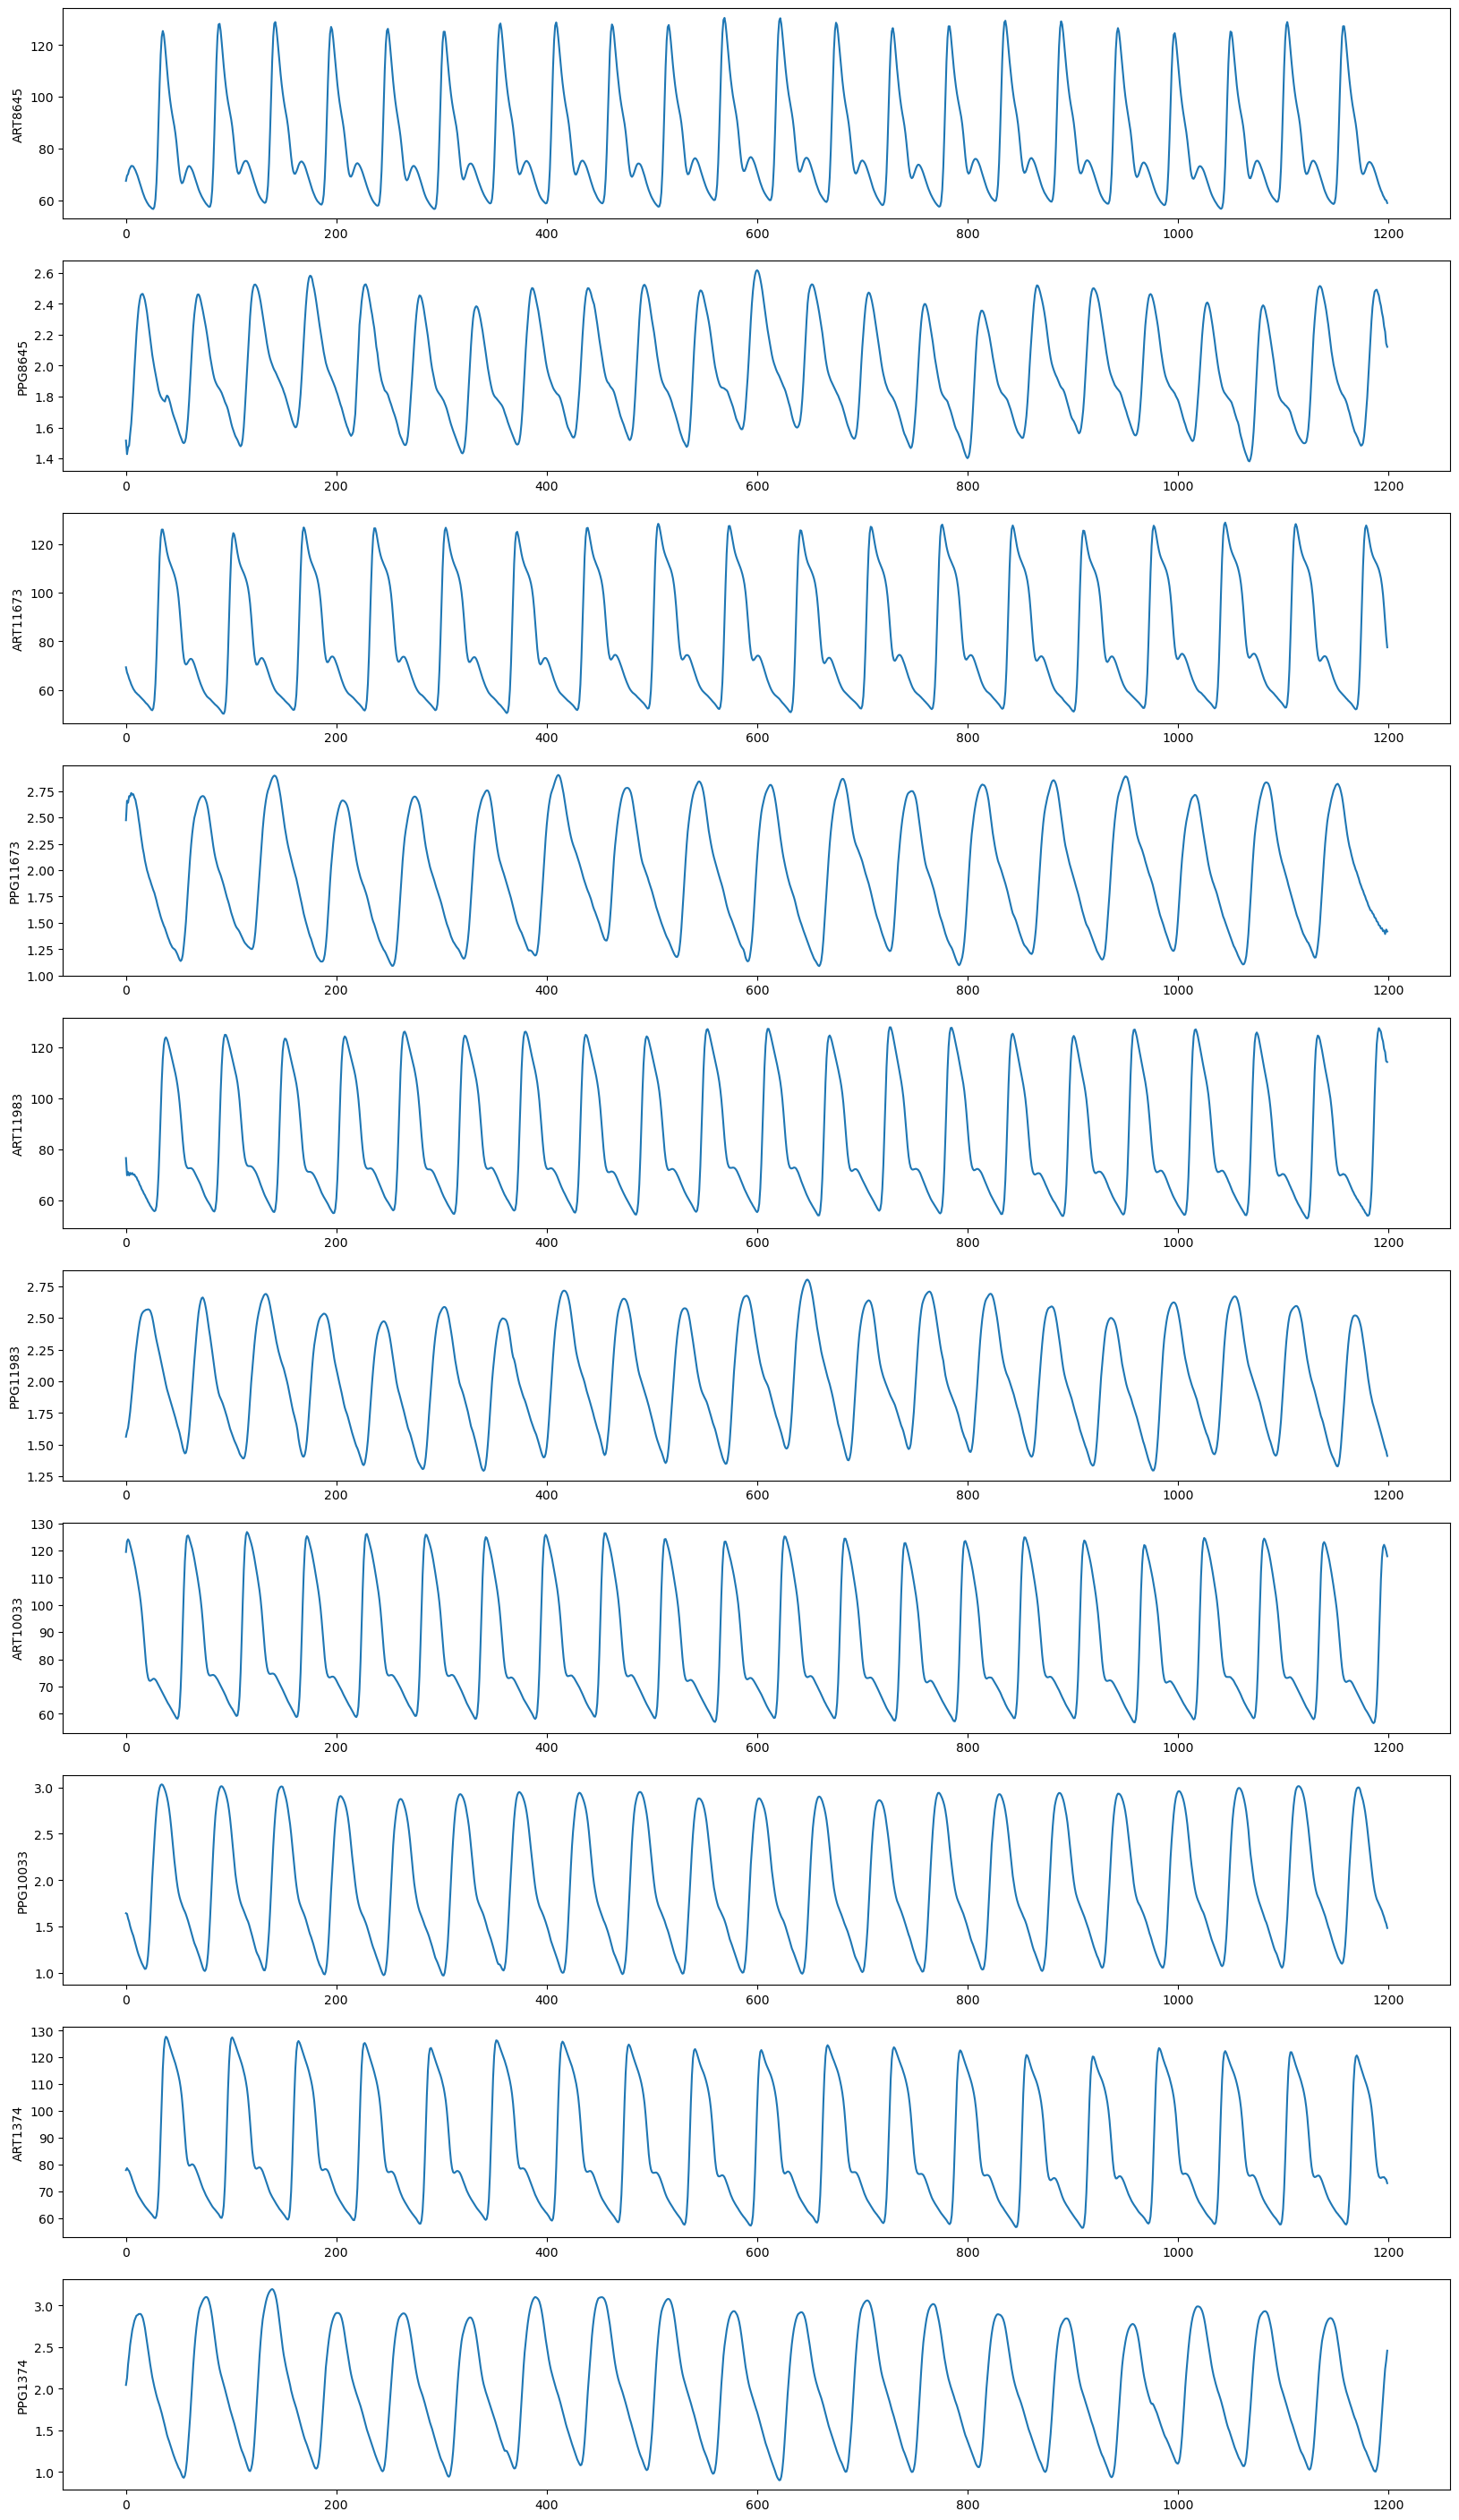

In [14]:
import random as rd
randomID=[]                        

for i in range(5):
    a = rd.randrange(0,len(data['ART']))       
    while a in randomID:              
        a = rd.randint(0,len(data['ART']))
    randomID.append(a) 

plt.figure(figsize=(20,36))

for i in range(5):
    plt.subplot(10,1,2*i+1)
    plt.plot(data['ART'][randomID[i]])
    plt.ylabel('ART'+ str(randomID[i]))

    plt.subplot(10,1,2*i+2)
    plt.plot(data['PLETH'][randomID[i]])
    plt.ylabel('PPG'+ str(randomID[i]))
plt.show()

Below is the code to check the results  
It doesn't matter if you don't run it

std_peak_dist_PPG: 2.3531234737354154
std_peaks_PPG: 0.029624548011507566
max_min_differ_pks: 0.0863180044801688
max_differ_pks: 0.05565592436109412


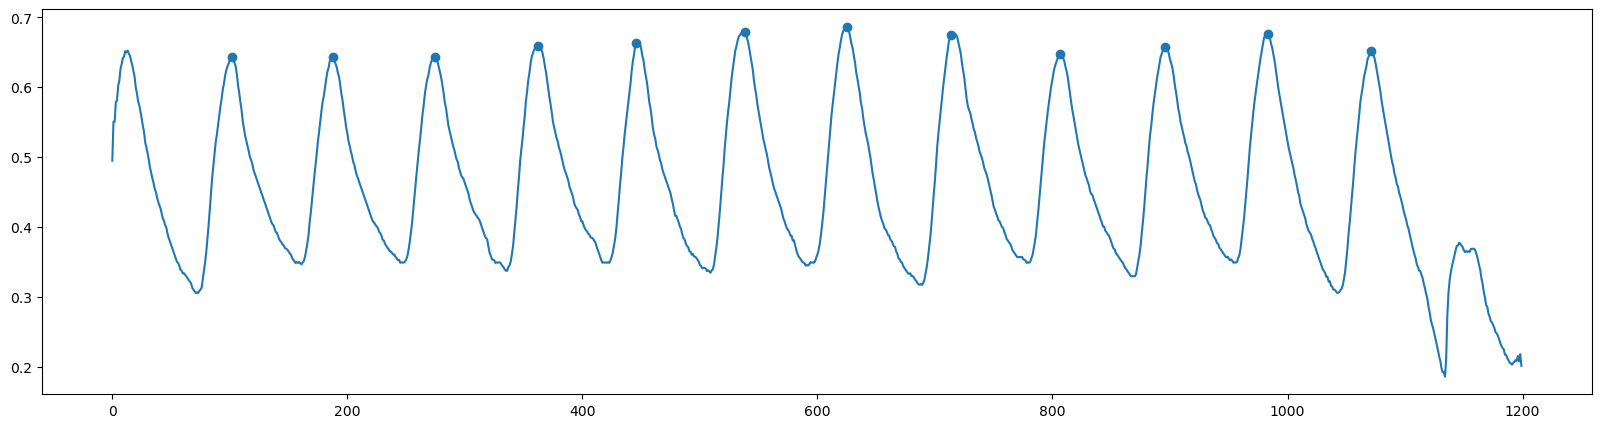

In [18]:
dataID = 115994

PPG = data['PLETH'][dataID]
PPG = minmax_scale(PPG)
# Transpose the Signals if they are in column format, necessary for peak detection
if PPG.shape[0] > 1:
    PPG = PPG.T

try:
    wd_p, _ = hp.process(PPG, sample_rate=125) # peak 검출
except Exception:
    print('heartpy error')

# Peak
pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
pks_PPG = np.array(pks_PPG)

if pks_PPG[-1] == (1499):
    pks_PPG = np.delete(pks_PPG,-1)

peak_dist_PPG = get_difference_list(pks_PPG) # peak 간격 리스트
std_peak_dist_PPG = np.std(peak_dist_PPG)    # peak 간격의 std, feature 1
std_peaks_PPG = np.std(PPG[pks_PPG])         # peak 값의 std, feature 2
num_peaks_PPG = len(pks_PPG)                 # peak 갯수, feature 3
max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # 최대 peak와 최소 peak 차이, feature 4
differ_pks = get_difference_list(PPG[pks_PPG])
max_differ_pks = max(np.abs(differ_pks))     # peak간 차분값의 최댓값, feature 5

print('std_peak_dist_PPG:',std_peak_dist_PPG) # 10
print('std_peaks_PPG:',std_peaks_PPG) # 0.1
print('max_min_differ_pks:',max_min_differ_pks) # 0.3
print('max_differ_pks:',max_differ_pks) # 0.2


plt.figure(figsize=(20,5))
plt.plot(data['PLETH'][dataID])
plt.scatter(pks_PPG, data['PLETH'][dataID][pks_PPG])
plt.show()

std_peak_dist_ABP: 3.8208165954128592
std_peaks_ABP: 0.0707353600547809
max_min_differ_pks: 0.26484977995543635
max_differ_pks: 0.10153321751031896


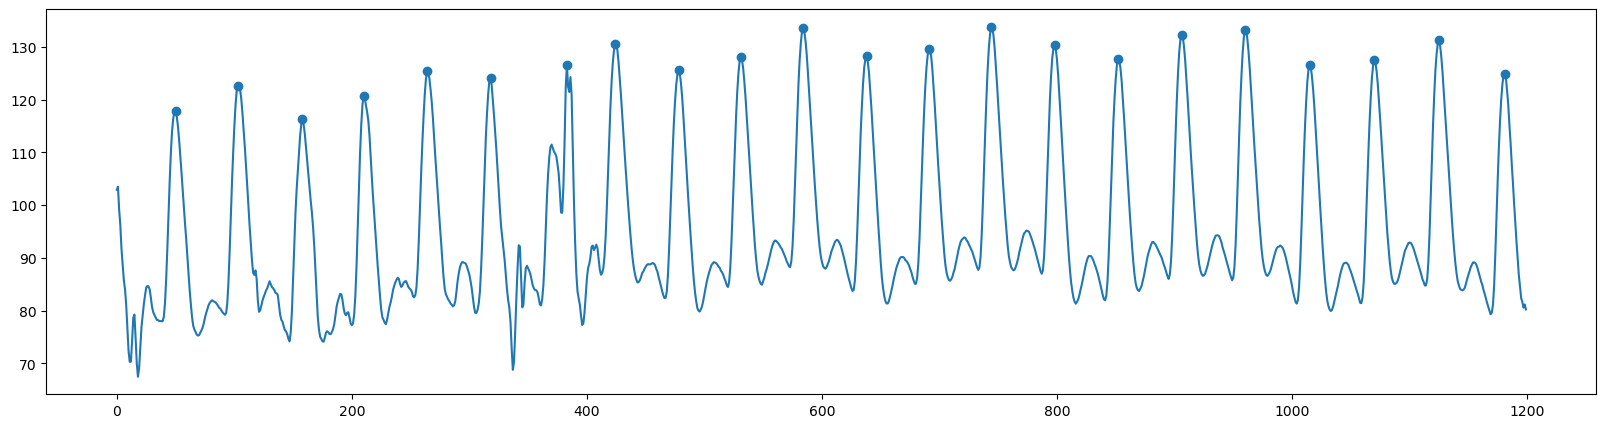

In [58]:
dataID = 3

ABP = data['ART'][dataID]
ABP = minmax_scale(ABP)
# Transpose the Signals if they are in column format, necessary for peak detection
if ABP.shape[0] > 1:
    ABP = ABP.T

try:
    wd_p, _ = hp.process(ABP, sample_rate=125) # peak 검출
except Exception:
    print('heartpy error')

# Peak
pks_ABP = wd_p['peaklist'] # peak의 위치 리스트
pks_ABP = np.array(pks_ABP)

if pks_ABP[-1] == (1499):
    pks_ABP = np.delete(pks_ABP,-1)

peak_dist_ABP = get_difference_list(pks_ABP) # peak 간격 리스트
std_peak_dist_ABP = np.std(peak_dist_ABP) # peak 간격의 std, feature 1
std_peaks_ABP = np.std(ABP[pks_ABP]) # peak 값의 std, feature 2
num_peaks_ABP = len(pks_ABP) # peak 갯수, feature 3
max_min_differ_pks = np.max(ABP[pks_ABP]) - np.min(ABP[pks_ABP]) # 최대 peak와 최소 peak 차이, feature 4
differ_pks = get_difference_list(ABP[pks_ABP])
max_differ_pks = max(np.abs(differ_pks)) # peak간 차분값의 최댓값, feature 5

print('std_peak_dist_ABP:',std_peak_dist_ABP) # 10
print('std_peaks_ABP:',std_peaks_ABP) # 0.1
print('max_min_differ_pks:',max_min_differ_pks) # 0.3
print('max_differ_pks:',max_differ_pks) # 0.2


plt.figure(figsize=(20,5))
plt.plot(data['ART'][dataID])
plt.scatter(pks_ABP, data['ART'][dataID][pks_ABP])
plt.show()

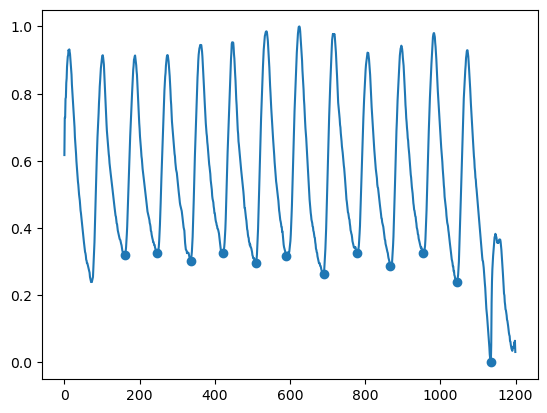

In [37]:
sample=PPG

try:
    wd_p, _ = hp.process(PPG, sample_rate=125) # peak 검출
except Exception:
    print('heartpy error')

# Peak
pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
pks_PPG = np.array(pks_PPG)

if pks_PPG[-1] == (1499):
    pks_PPG = np.delete(pks_PPG,-1)

# Valley
P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])

if all(np.gradient(sample[-3:])<0):
    val_PPG = np.concatenate([val_PPG, [np.argmin(PPG[pks_PPG[-1]:len(sample)])+pks_PPG[-1]]], axis=-1)


plt.plot(sample)
plt.scatter(val_PPG, PPG[val_PPG])
plt.show()